In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import copy
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_data():
    train_df = pd.read_csv('Data/my_data/final_data/train3.csv')
    test_df = pd.read_csv('Data/my_data/final_data/test3.csv')
    
    base_columns = []
    for col in train_df.columns:
        if col == 'user' or col == 'song':
            continue
        base_columns.append(col)
        if col == 'user_count':
            break
            
    df_train = train_df[base_columns]
    df_test = test_df[base_columns]
    df_all = pd.concat([df_train, df_test])
    
    ua_svd = df_all['svd_ua']
    ua_svd_fixed = []
    for x in ua_svd:
        try:
            ua_svd_fixed.append(float(x))
        except:
            ua_svd_fixed.append(float(x[2:-2]))
    df_all['svd_ua'] = ua_svd_fixed
    
    if 's_country' in df_all.columns:
        df_all['country'] = pd.factorize(df_all['s_country'])[0] + 1
        df_all = df_all[[i for i in list(df_all.columns) if 's_country' != i]]
        
    return df_all, len(train_df), len(test_df)

In [3]:
def split_data(df_all, train_len, test_len):
    
    X = df_all[[x for x in df_all.columns if 'count' not in x and 'sim' not in x and x != 'target' and x != 'user' and x != 'song']]
    Y = df_all['target']
    
    train_set_x = X.head(train_len)
    train_set_y = Y.head(train_len)
    test_set_x = X.tail(test_len)
    test_set_y = Y.tail(test_len)
    
    return train_set_x, train_set_y, test_set_x, test_set_y

In [4]:
df_all, train_len, test_len = get_data()

C:\Users\yamsharon102\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [5]:
df_all.head()

,age_diff,exp_DM,exp_MY,exp_Y,exp_YMD,reg_DM,reg_MY,reg_Y,reg_YMD,s_year,sim_us,svd_ua,svd_us,target,u_age,user_count,country
0,2.0,510.0,102017.0,2017.0,20171005.0,201.0,12012.0,2012.0,20120102.0,2016.0,0.056927,0.389718,0.557183,1,0.0,1287,1
1,2.0,510.0,102017.0,2017.0,20171005.0,201.0,12012.0,2012.0,20120102.0,2016.0,0.052756,0.441807,0.549274,1,0.0,1287,2
2,21.0,403.0,32018.0,2018.0,20180304.0,711.0,112011.0,2011.0,20111107.0,2013.0,0.020542,0.811370,0.839421,1,26.0,247,2
3,10.0,3009.0,92017.0,2017.0,20170930.0,2012.0,122015.0,2015.0,20151220.0,2010.0,-0.136646,0.381177,0.470182,0,18.0,84,1
4,6.0,3009.0,92017.0,2017.0,20170930.0,2012.0,122015.0,2015.0,20151220.0,2006.0,-0.085568,0.347342,0.444218,0,18.0,84,1


In [6]:
train_set_x, train_set_y, test_set_x, test_set_y = split_data(df_all, train_len, test_len)

In [7]:
model1 = lgbm.LGBMClassifier(learning_rate=0.05, max_depth=15, 
                             num_leaves=2**8, colsample_bytree=0.7,
                             subsample=0.7)
model1.fit(train_set_x, train_set_y, verbose=1)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        importance_type='split', learning_rate=0.05, max_depth=15,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=256, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [8]:
model2 = lgbm.LGBMClassifier(learning_rate=0.1, max_depth=15, 
                             num_leaves=2**8, colsample_bytree=0.9,
                             subsample=0.9)
model2.fit(train_set_x, train_set_y, verbose=1)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.1, max_depth=15,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=256, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [12]:
y1 = [x[1] for x in model1.predict_proba(train_set_x)]
print('model1 train AUC',roc_auc_score(train_set_y, y1))
y2 = [x[1] for x in model2.predict_proba(train_set_x)]
print('model2 train AUC',roc_auc_score(train_set_y, y2))
ensemble_train = [(y1[i]+y2[i])/2 for i in range(len(y1))]
print('ensemble_train train AUC',roc_auc_score(train_set_y, ensemble_train))

model1 train AUC 0.8726497521209631
model2 train AUC 0.8818882156234666
ensemble_train train AUC 0.8778851381621875


In [13]:

y_pred1 = [x[1] for x in model1.predict_proba(test_set_x)]
print('model1 test AUC',roc_auc_score(test_set_y, y_pred1))
y_pred2 = [x[1] for x in model2.predict_proba(test_set_x)]
print('model2 test AUC',roc_auc_score(test_set_y, y_pred2))
ensemble_test = [(y_pred1[i]+y_pred2[i])/2 for i in range(len(y_pred1))]
print('ensemble_test test AUC',roc_auc_score(test_set_y, ensemble_test))


model1 test AUC 0.5868544340188491
model2 test AUC 0.5789327660093572
model3 test AUC 0.6046490862371855
ensemble_test test AUC 0.5833966231288604


No handles with labels found to put in legend.


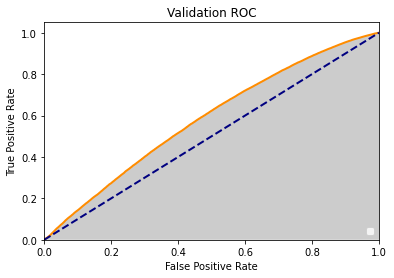

In [16]:
# Prints ROC graph
fpr, tpr, thresholds = roc_curve(test_set_y, ensemble_test)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")
plt.fill_between(fpr, tpr, facecolor='grey', step="pre", alpha=0.4)
plt.show()